In [38]:
from google.colab import drive
drive.mount("/content/gdrive")
%cd /content/gdrive/MyDrive/PHD-2023/lsr_clean

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
/content/gdrive/MyDrive/PHD-2023/lsr_clean


In [39]:
import torch
import torch.nn as nn
import torch.utils.data
import torch.nn.functional as F
import numpy as np
import pandas as pd
import time
from transformers import PreTrainedModel, PreTrainedTokenizer
from transformers import AutoTokenizer, AutoModel
from sentence_transformers import SentenceTransformer
from sklearn.metrics import classification_report
from sklearn.cluster import MiniBatchKMeans
from sklearn import metrics
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.decomposition import TruncatedSVD
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import Normalizer

import json
import string
from collections import defaultdict
from typing import List
import csv
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score, accuracy_score
from sklearn.cluster import KMeans
from sklearn.metrics import normalized_mutual_info_score, adjusted_rand_score
from torch.utils.data import Dataset, TensorDataset, DataLoader
from tqdm import tqdm

import nltk
from nltk.tag import pos_tag
from nltk.corpus import stopwords
nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger')
nltk.download('universal_tagset')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package universal_tagset to /root/nltk_data...
[nltk_data]   Package universal_tagset is already up-to-date!


True

In [40]:
%load_ext autoreload
%autoreload 2
import model
from utils import*
import trainer
from trainer import LSRTrainer

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Topic Detection Task (TD dataset)

In [41]:
my_data = pd.read_csv('data/TD_labels.csv')
ground_truth_label = my_data.keyword.tolist()
label_map = {}
for (i, label) in enumerate(my_data.keyword.unique().tolist()):
  label_map[label] = i
print(label_map)
print(my_data.groupby(my_data['keyword']).count())
ground_truth_label = my_data.keyword.tolist()
labels = [label_map[i] for i in ground_truth_label]
keywords_list = [['music'],['sports'], ['cybersecurity'], ['movie'], ['health']]
security_class = label_map.get('cybersecurity')
n_clusters = len(label_map)

{'music': 0, 'sports': 1, 'cybersecurity': 2, 'movie': 3, 'health': 4}
                IDS
keyword            
cybersecurity  1498
health         1064
movie          1469
music          1477
sports         1884


In [42]:
#load the presaved embeddings
s_embeddings = np.load(f'data/TD_embeddings.npy', allow_pickle=True)
word_vectors = np.load(f'data/TD_LSA_feature.npy', allow_pickle=True)

### Compute Embeddings
Compute embeddings for documents using either SentenceBERT model or any other BERT model. Recomment SentenceBERT T5 as used in the paper

In [43]:
model_name = "sentence-t5-base"
transformer_model = SentenceTransformer(model_name)
transformer_model.max_seq_length = 128
tokenizer = None
# s_embeddings = transformer_model.encode(documents)
label_embeddings = compute_PLM_label_embeddings(transformer_model, keywords_list, tokenizer)

In [ ]:
# model_name = "roberta-base"
# transformer_model = AutoModel.from_pretrained(model_name)
# tokenizer = AutoTokenizer.from_pretrained(model_name)
# s_embeddings = compute_transformer_mean_embeddings(documents.tolist(), transformer_model, tokenizer, batch_size=16)
# print(custom_embeddings.shape)  # torch.Size([3, hidden_size])
# label_embeddings = compute_PLM_label_embeddings(transformer_model, keywords_list, tokenizer)

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


torch.Size([9384, 768])


### Run LSR

Seed is 91
Converting texts into tensors.
per epoch loss is tensor(1.7148, grad_fn=<AddBackward0>)


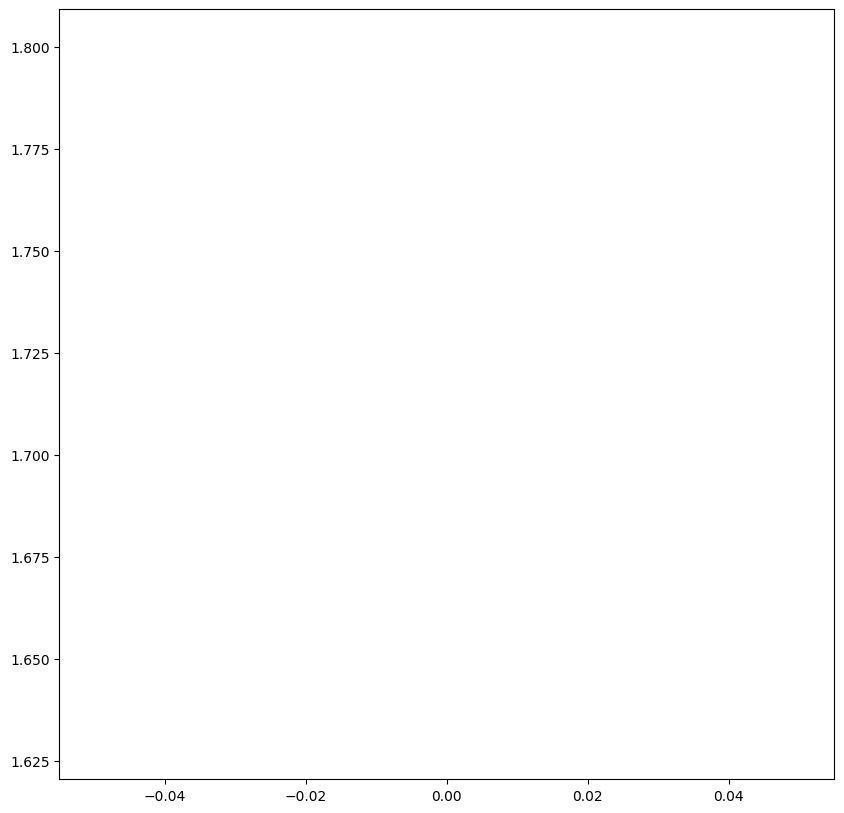

100%|██████████| 231/231 [00:00<00:00, 401.58batch/s]
/usr/local/lib/python3.11/dist-packages/torch/nn/_reduction.py:51: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
  0%|          | 0/231 [00:00<?, ?batch/s]/content/gdrive/MyDrive/PHD-2023/lsr_clean/utils.py:166: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  batch = torch.tensor(batch)
/content/gdrive/MyDrive/PHD-2023/lsr_clean/utils.py:167: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  cluster_centers = torch.tensor(cluster_centers)
100%|██████████| 231/231 [00:04<00:00, 50.14batch/s] 


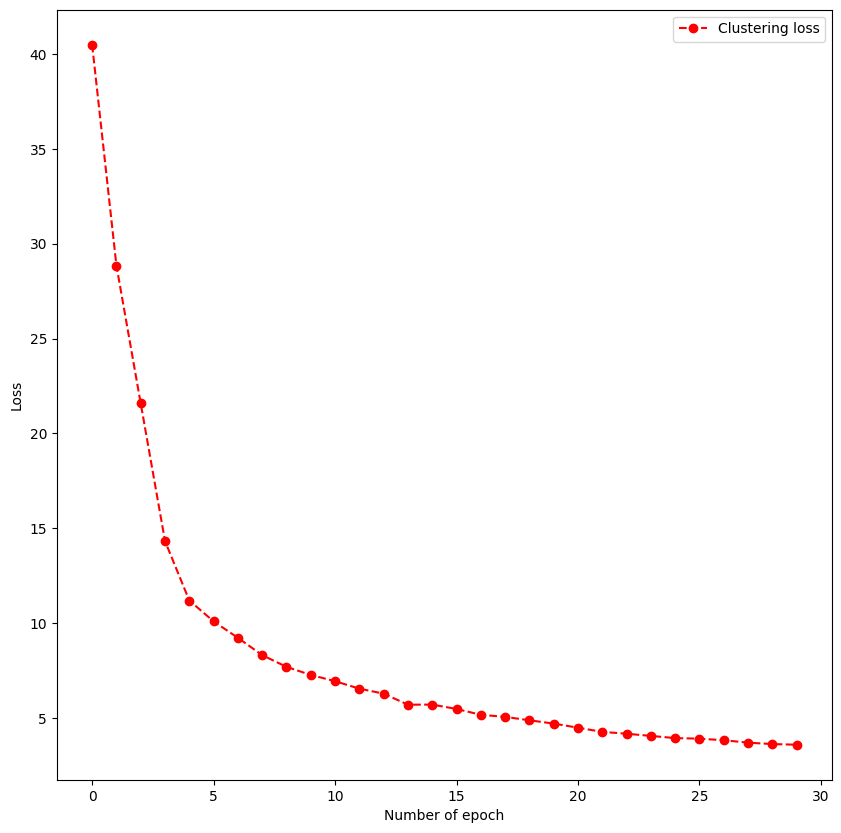

100%|██████████| 1/1 [00:00<00:00, 519.10batch/s]


how many docs to refine labels? 5
what is label vec col? label_vector_from_docs
sim_matrix_dimension: (7392, 5)
              precision    recall  f1-score      support
0              0.949488  0.941774  0.945615  1477.000000
1              0.956044  0.923567  0.939525  1884.000000
2              0.986056  0.991322  0.988682  1498.000000
3              0.956667  0.976855  0.966655  1469.000000
4              0.920981  0.953008  0.936721  1064.000000
accuracy       0.955763  0.955763  0.955763     0.955763
macro avg      0.953847  0.957305  0.955440  7392.000000
weighted avg   0.955893  0.955763  0.955691  7392.000000
  seed           accuracy        f1_security         f1_weighted  \
0   91  0.955762987012987  0.988681757656458  0.9556914596300412   

   precision_weighted    recall_weighted            f1_macro  \
0  0.9558927573975065  0.955762987012987  0.9554395634440203   

     precision_macro        recall_macro run_time  
0  0.953847076128216  0.9573050058951684     56.4  


In [45]:
accuracy = []
f1_security = []

f1_weighted = []
precision_weighted = []
recall_weighted = []

f1_macro = []
precision_macro = []
recall_macro = []
run_time = []
random_seed = []


cluster_number = len(set(labels))
epochs = 30
batch_size = 32
lr = 0.0001
latent_size = 100
vectorizer = TfidfVectorizer(
    max_df=0.7,
    min_df=5,
    stop_words="english",
)

minibatch_kmeans = MiniBatchKMeans(
    n_clusters=cluster_number,
    n_init=1,
    init_size=1000,
    batch_size=1000,
)


lsr_trainer = LSRTrainer(
  cluster_number = cluster_number,
  input_dim = s_embeddings.shape[1],
  hidden_dims = [100,100],
  hidden_dimension = latent_size,
  epochs = epochs,
  batch_size = 32,
  lr = lr,
  sampler = None,
  update_freq = 100
)

for run in range(1):#how many times to run
  seed = np.random.randint(100)
  print(f'Seed is {seed}')
  random_seed.append(seed)
  np.random.seed(seed)
  torch.manual_seed(seed)
  start_time = time.time()
  # X_tfidf = vectorizer.fit_transform(documents)
  # print(f"n_samples: {X_tfidf.shape[0]}, n_features: {X_tfidf.shape[1]}")
  # lsa = make_pipeline(TruncatedSVD(n_components=latent_size, random_state = seed), Normalizer(copy=False))
  # X_lsa = lsa.fit_transform(X_tfidf)
  #create the auxilury distribution from word vectors from TF-IDF
  X_lsa = word_vectors
  minibatch_kmeans.fit(X_lsa)
  centroids = minibatch_kmeans.cluster_centers_
  print(f"Converting texts into tensors.")
  lsr_dataset = TensorDataset(torch.tensor(s_embeddings), torch.tensor(labels).to(torch.long),torch.tensor(X_lsa))
  #Step1: LSR initialization module
  lsr_trainer.pretrain(lsr_dataset,pretrain_epoch = 50, pretrain_lr = 0.01)
  #Step2: LSR clustering module
  lsr_trainer.train(lsr_dataset, centroids, evaluate_every = 1)
  # allfeatures = latent_embedding.clone().detach().cpu().numpy()
  #Step3: LSR classification
  res_df = lsr_trainer.classification(lsr_dataset, keywords_list, label_embeddings)
  pred_y = res_df.pred_label.tolist()
  run_time.append("{:.1f}".format((time.time() - start_time)))
  report = classification_report(labels, pred_y, digits=3, output_dict=True)
  result_df = pd.DataFrame(report).transpose()
  print(result_df)
  accuracy.append(result_df.loc['accuracy'].tolist()[0])
  f1_security.append(result_df.loc[str(security_class)].tolist()[2])
  f1_weighted.append(result_df.loc['weighted avg'].tolist()[2])
  precision_weighted.append(result_df.loc['weighted avg'].tolist()[0])
  recall_weighted.append(result_df.loc['weighted avg'].tolist()[1])

  f1_macro.append(result_df.loc['macro avg'].tolist()[2])
  precision_macro.append(result_df.loc['macro avg'].tolist()[0])
  recall_macro.append(result_df.loc['macro avg'].tolist()[1])
  columns = [
      "seed",
    "accuracy",
    "f1_security",
    "f1_weighted",
    "precision_weighted",
    "recall_weighted",
    "f1_macro",
    "precision_macro",
    "recall_macro",
    "run_time"
  ]
  out_res = [random_seed, accuracy, f1_security, f1_weighted, precision_weighted, recall_weighted, f1_macro, precision_macro, recall_macro, run_time]
  out_res = np.array(out_res).T
  final_df = pd.DataFrame(out_res, columns=columns)
  print(final_df)
  # Save to CSV